In [40]:
!pip install segmentation-models-pytorch

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm



In [42]:
train_data_path = '/content/train.csv'

#select device to train on
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

epochs = 25
leraning_rate = 0.001
img_size = 320
batch_size = 32

ENCODER = 'timm-efficients-b0'
WEIGHTS = 'imagenet'


cuda:0


In [43]:
data = pd.read_csv(train_data_path)
print(data.shape)
data.head()


(290, 2)


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [44]:
sample = data.iloc[np.random.randint(0,data.shape[0],size = 5)]
def generate_sample_images(sample):
  imgs = sample.images
  _,ax = plt.subplots(1,5,figsize = (15,3))
  for i,image in enumerate(imgs):
    image = cv2.imread(image)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    ax[i].set_title("IMAGE")
    ax[i].imshow(image)

def generate_sample_masks(sample):
  masks = sample.masks
  _,ax = plt.subplots(1,5,figsize = (15,3))
  ax = ax.flatten()
  for i,mask in enumerate(masks):
    mask = cv2.imread(mask,cv2.IMREAD_GRAYSCALE)
    ax[i].set_title("GROUND TRUTH")
    ax[i].imshow(mask,cmap = 'gray')


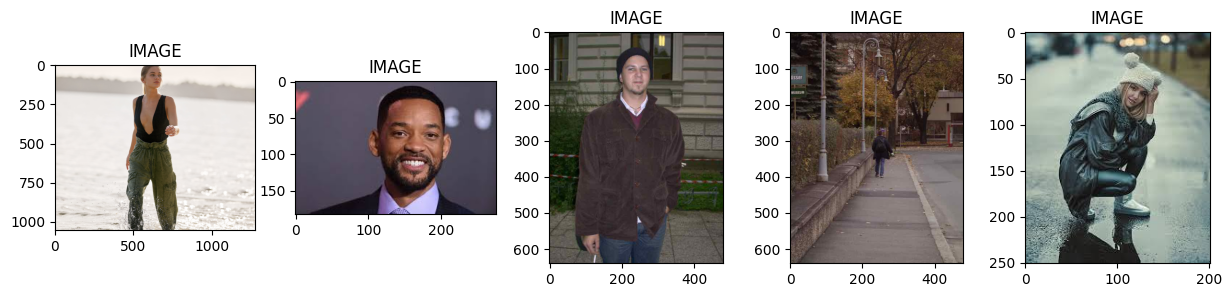

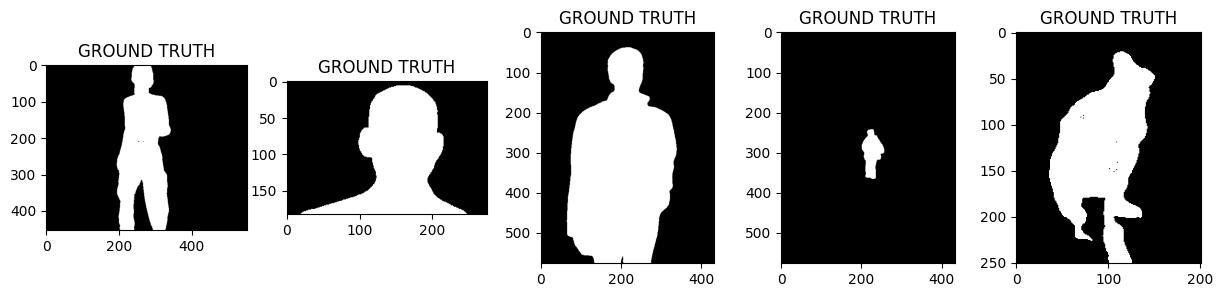

In [45]:
generate_sample_images(sample)
generate_sample_masks(sample)

#Split the data#

In [46]:
train_data,val_data = train_test_split(data,test_size = 0.2,random_state = 57)


#Data Augmentation

In [47]:
import albumentations as A


In [48]:
from operator import is_
def get_train_augmentation():
  return A.Compose([
      A.Resize(img_size,img_size),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ],is_check_shapes=False)

def get_val_augmentation():
  return A.Compose([
      A.Resize(img_size,img_size)
  ],is_check_shapes=False)


#Preprocessing the Data#

In [49]:
from torch.utils.data import Dataset


#Create the custom datset class #

In [50]:
class custom_dataset(Dataset):
  def __init__(self,data,augmentation):
    self.data = data
    self.augmentation = augmentation

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    sample = self.data.iloc[index]
    image = sample.images
    mask = sample.masks

    #Read the images and masks
    image = cv2.imread(image)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask,cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask,axis = -1)

    if self.augmentation:
      data_set = self.augmentation(image = image,mask=mask)
      image = data_set['image']
      mask = data_set['mask']

    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image,mask



In [51]:
train_dataset = custom_dataset(train_data,get_train_augmentation())
val_dataset = custom_dataset(val_data,get_val_augmentation())


In [52]:
print(f"Size of Trainset : {len(train_dataset)}")
print(f"Size of Validset : {len(val_dataset)}")

Size of Trainset : 232
Size of Validset : 58


In [53]:
def process_image(index):
  image,mask = train_dataset[index]
  plt.subplot(1,2,1)
  plt.imshow(np.transpose(image,(1,2,0)))
  plt.axis('off')
  plt.title('IMAGE')
  plt.subplot(1,2,2)
  plt.imshow(np.transpose(mask,(1,2,0)))
  plt.axis('off')
  plt.title('GROUND TRUTH')
  plt.show()

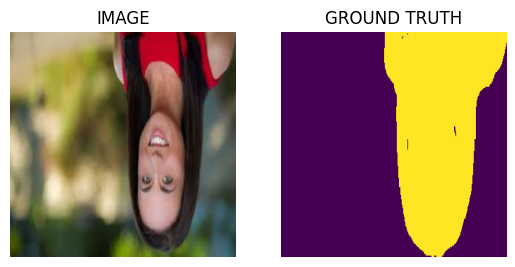

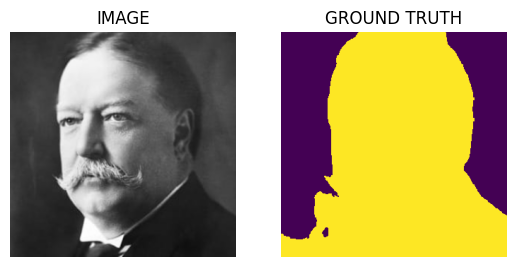

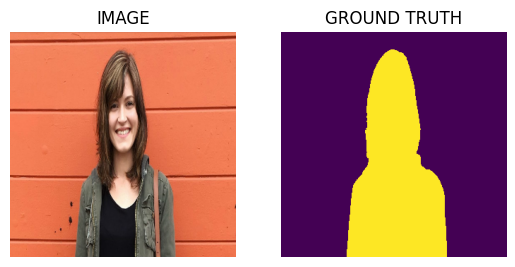

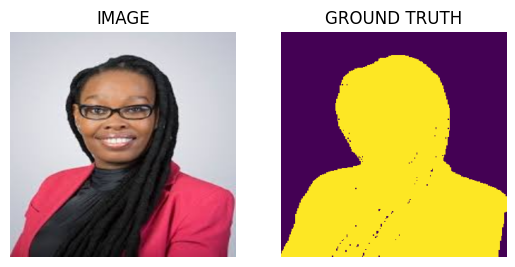

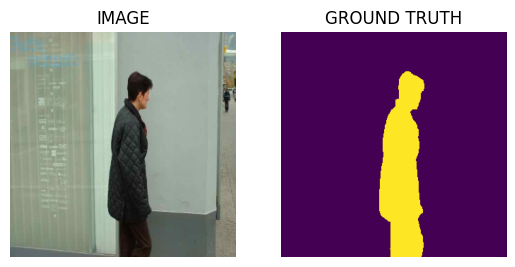

In [54]:
for i in np.random.randint(0, len(train_dataset), 5):
    process_image(i)

In [55]:
from torch.utils.data import DataLoader


In [56]:
trainloader = DataLoader(train_dataset,batch_size = batch_size,shuffle = True)
valloader = DataLoader(val_dataset,batch_size = batch_size,shuffle = True)

print(f"Size of Trainloader : {len(trainloader)}")
print(f"Size of Valloader : {len(valloader)}")

Size of Trainloader : 8
Size of Valloader : 2


In [57]:
for image,mask in trainloader:
  print(f"Image batch shape : {image.shape}")
  print(f"Mask batch shape : {mask.shape}")
  break

Image batch shape : torch.Size([32, 3, 320, 320])
Mask batch shape : torch.Size([32, 1, 320, 320])


In [58]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [59]:
ENCODER = 'efficientnet-b0'  # Change this to a supported encoder
WEIGHTS = 'imagenet'


class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.model = smp.UnetPlusPlus(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None)

    def forward(self, images, masks=None):
        logits = self.model(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [60]:
model = SegmentationModel()
model.to(device);

#Create Train and Validation Function#

In [61]:
def train_model(data_loader,model,optimizer):
  total_loss = 0.0
  model.train()


  for image,mask in tqdm(data_loader):
    image = image.to(device)
    mask = mask.to(device)

    optimizer.zero_grad()
    logits,loss = model(image,mask)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)


In [62]:
#Function to evaluate the model
def evaluate_model(data_loader,model):
  total_loss = 0.0
  model.eval()

  with torch.no_grad():
    for image,mask in tqdm(data_loader):
      image = image.to(device)
      mask = mask.to(device)

      logits,loss = model(image,mask)
      total_loss += loss.item()

    return total_loss / len(data_loader)


#Model Trainning#

In [63]:
optimizer = torch.optim.Adam(model.parameters(),lr = leraning_rate)


In [64]:
best_val_loss = 1e9

for i in range(epochs):
  train_loss = train_model(trainloader,model,optimizer)
  val_loss = evaluate_model(valloader,model)
  if val_loss < best_val_loss:
    torch.save(model.state_dict(),'best_model.pth')
    print("Model saved Successfully!")
    best_val_loss = val_loss

  print(f"Epoch : {epochs+1}/{epochs}")
  print(f"Train Loss : {train_loss:.4f}")
  print(f"Val Loss : {val_loss:.4f}")

100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Model saved Successfully!
Epoch : 26/25
Train Loss : 1.0456
Val Loss : 1.9402


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Model saved Successfully!
Epoch : 26/25
Train Loss : 0.5446
Val Loss : 0.4823


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


Model saved Successfully!
Epoch : 26/25
Train Loss : 0.3528
Val Loss : 0.4345


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


Model saved Successfully!
Epoch : 26/25
Train Loss : 0.2836
Val Loss : 0.3740


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


Epoch : 26/25
Train Loss : 0.2231
Val Loss : 0.4752


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Epoch : 26/25
Train Loss : 0.1944
Val Loss : 0.4627


100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


Model saved Successfully!
Epoch : 26/25
Train Loss : 0.1688
Val Loss : 0.3409


100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


Model saved Successfully!
Epoch : 26/25
Train Loss : 0.1411
Val Loss : 0.2835


100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


Epoch : 26/25
Train Loss : 0.1509
Val Loss : 0.3336


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Epoch : 26/25
Train Loss : 0.1626
Val Loss : 0.2917


100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Epoch : 26/25
Train Loss : 0.1444
Val Loss : 0.2848


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Epoch : 26/25
Train Loss : 0.1265
Val Loss : 0.3547


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Epoch : 26/25
Train Loss : 0.1225
Val Loss : 0.3061


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


Model saved Successfully!
Epoch : 26/25
Train Loss : 0.1030
Val Loss : 0.2664


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch : 26/25
Train Loss : 0.1317
Val Loss : 0.2792


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


Model saved Successfully!
Epoch : 26/25
Train Loss : 0.1164
Val Loss : 0.2170


100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Model saved Successfully!
Epoch : 26/25
Train Loss : 0.1123
Val Loss : 0.1938


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Epoch : 26/25
Train Loss : 0.1096
Val Loss : 0.2224


100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


Epoch : 26/25
Train Loss : 0.1016
Val Loss : 0.2334


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


Epoch : 26/25
Train Loss : 0.0945
Val Loss : 0.2209


100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


Model saved Successfully!
Epoch : 26/25
Train Loss : 0.0931
Val Loss : 0.1932


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


Epoch : 26/25
Train Loss : 0.0798
Val Loss : 0.2053


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


Epoch : 26/25
Train Loss : 0.0758
Val Loss : 0.2069


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Epoch : 26/25
Train Loss : 0.0784
Val Loss : 0.2086


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

Model saved Successfully!
Epoch : 26/25
Train Loss : 0.0817
Val Loss : 0.1842


In [65]:
model.load_state_dict(torch.load("best_model.pth"))
def make_inference(index):
  image,mask = val_dataset[index]
  logits_mask = model(image.to(device).unsqueeze(0))
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask > 0.5) * 1.0
  return image,mask,pred_mask

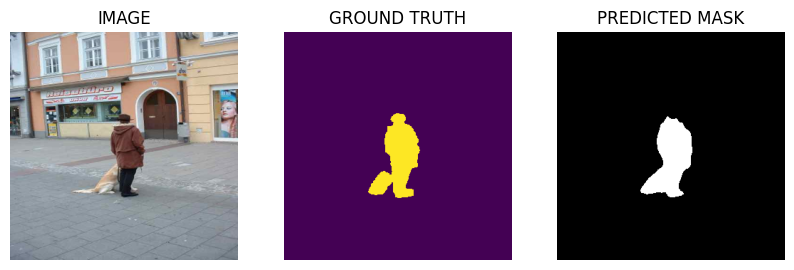

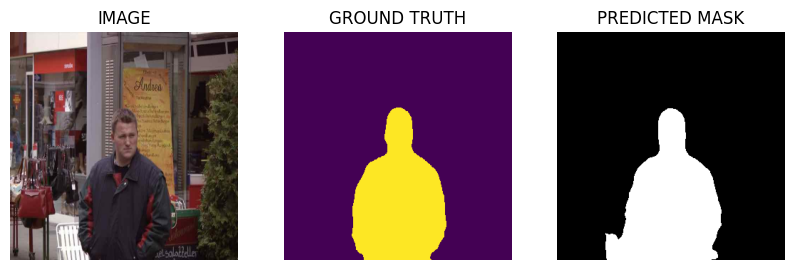

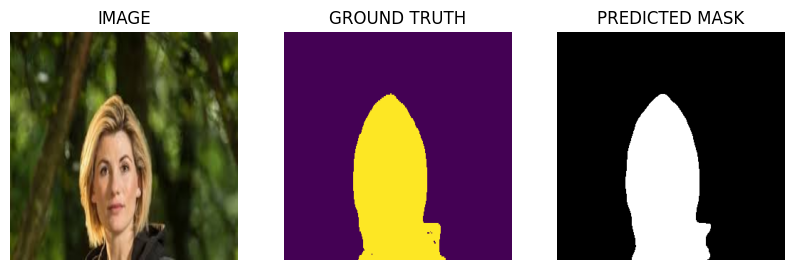

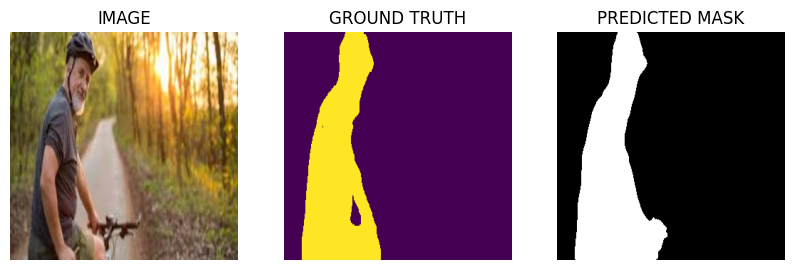

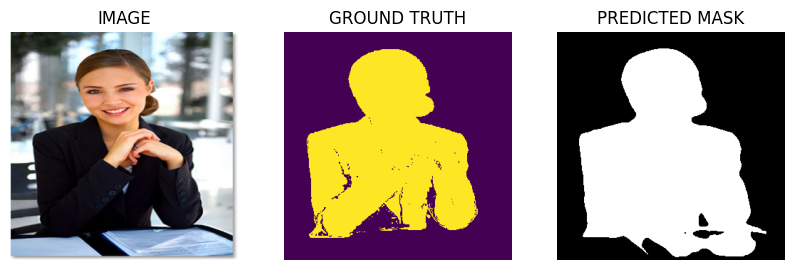

In [66]:
for i in np.random.randint(0,len(val_dataset),5):
  image,mask,pred_mask = make_inference(i)
  #Show the image
  plt.figure(figsize = (10,3))
  plt.subplot(1,3,1)
  plt.imshow(np.transpose(image,(1,2,0)))
  plt.axis('off')
  plt.title('IMAGE')
  #Show the original mask
  plt.subplot(1,3,2)
  plt.imshow(np.transpose(mask,(1,2,0)))
  plt.axis('off')
  plt.title('GROUND TRUTH')

  #Show the predicted mask
  plt.subplot(1,3,3)
  plt.imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
  plt.axis('off')
  plt.title('PREDICTED MASK')
  plt.show()